In [16]:
import cv2
import pytesseract
from matplotlib import pyplot as plt

In [23]:
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'  # Path to the Tesseract executable

In [39]:
def detect_plate_number(image_path):
    # Load and display original image
    image = cv2.imread(image_path)
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Convert to grayscale and display
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')
    
    # Apply Gaussian blur and display
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    plt.subplot(2, 3, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title('Blurred')
    plt.axis('off')
    
    # Edge detection and display
    edges = cv2.Canny(blurred, 100, 200)
    plt.subplot(2, 3, 4)
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')
    plt.axis('off')
    
    # Find contours
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Draw contours on original image
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours[:10], -1, (0, 255, 0), 2)
    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title('Contours')
    plt.axis('off')
    
    plate_contour = None
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        if len(approx) == 4:
            # Get bounding rectangle to check dimensions
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / h
            area = cv2.contourArea(contour)
            
            # Filter based on license plate characteristics
            # License plates typically have aspect ratio between 2:1 and 4:1
            # And reasonable area constraints
            if (2.0 <= aspect_ratio <= 4.5 and 
                1000 < area < 50000 and  # Area constraints
                w > 80 and h > 20):      # Minimum size constraints
                plate_contour = approx
                print(f"Found candidate: aspect_ratio={aspect_ratio:.2f}, area={area:.0f}, w={w}, h={h}")
                break
    
    if plate_contour is not None:
        # Draw detected plate contour
        image_with_plate = image.copy()
        cv2.drawContours(image_with_plate, [plate_contour], -1, (0, 0, 255), 3)
        
        # Extract plate region
        x, y, w, h = cv2.boundingRect(plate_contour)
        plate_image = gray[y:y + h, x:x + w]
        
        # Apply threshold to plate image
        _, thresh = cv2.threshold(plate_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        plt.subplot(2, 3, 6)
        plt.imshow(thresh, cmap='gray')
        plt.title('Extracted Plate (Thresholded)')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Show detected plate contour separately
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(image_with_plate, cv2.COLOR_BGR2RGB))
        plt.title('Detected Plate Contour')
        plt.axis('off')
        plt.show()
        
        plate_number = pytesseract.image_to_string(thresh, config='--psm 8')
        return plate_number.strip()
    else:
        plt.tight_layout()
        plt.show()
        return "No plate detected"

Found candidate: aspect_ratio=3.57, area=14833, w=239, h=67


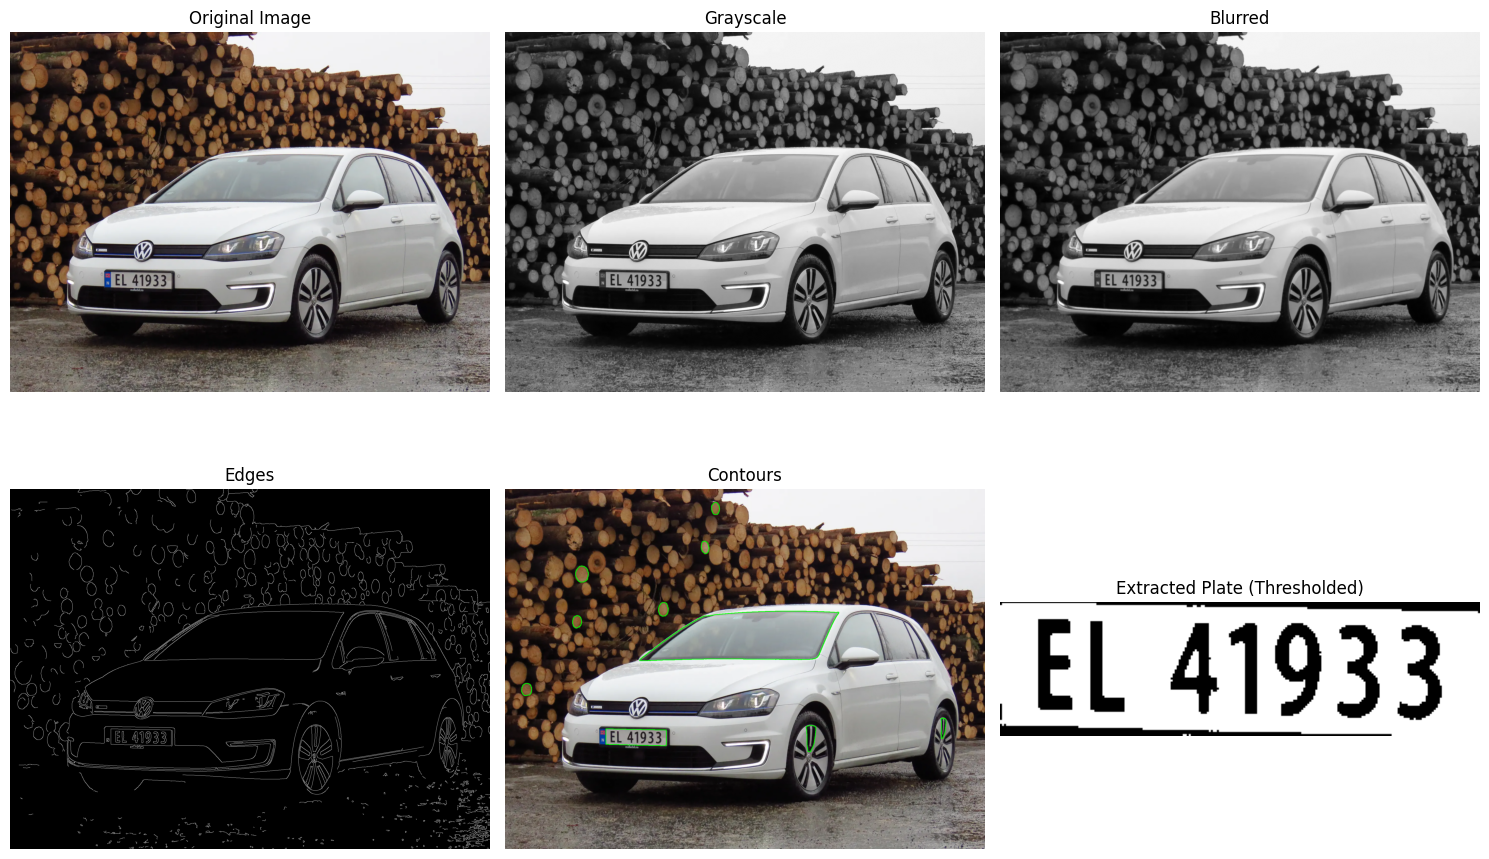

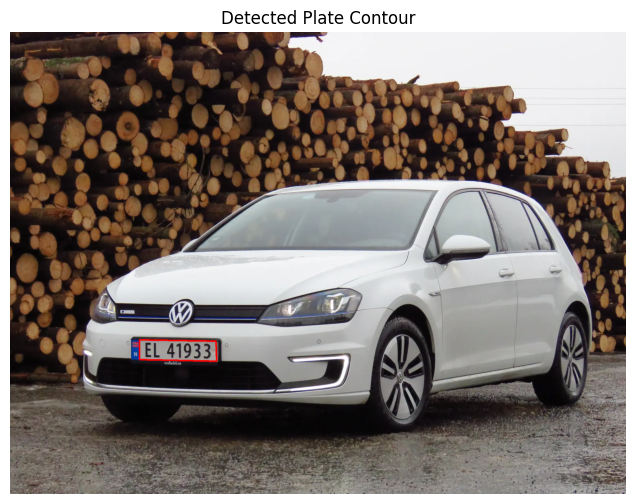

Detected Plate Number: EL 41933,


In [ ]:
import os

# Get all image files from the bilder folder
image_folder = 'bilder'
image_extensions = ['.jpg', '.jpeg', '.webp']
image_files = []

for file in os.listdir(image_folder):
    if any(file.lower().endswith(ext) for ext in image_extensions):
        image_files.append(os.path.join(image_folder, file))

# Process each image
for image_path in image_files:
    print(f"\nProcessing: {image_path}")
    plate_number = detect_plate_number(image_path)
    print("Detected Plate Number:", plate_number)   
